# Clustering 

elbow method, silhouette score, calinski-harabasz e davies-bouldin

In [2]:
# Data Manipulation
import pandas as pd
import numpy as np

# Data Viz
import matplotlib.pyplot as plt
import seaborn as sns

# Cluster Models
from sklearn.cluster import (
    KMeans,
    AgglomerativeClustering
)
from sklearn.mixture import GaussianMixture
from sklearn_extra.cluster import KMedoids

# Metrics
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score
)

In [3]:
df = pd.read_csv('../data/clusterization.csv')
print(df.shape)
df.head()

(15000, 10)


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9
0,1.788532,1.514571,1.965787,1.788532,1.839011,0.027213,4.287439,1.103957,0.272501,0.390037
1,1.137568,-0.537787,0.405860,1.137568,1.177157,0.881743,2.289545,-0.427406,-0.227506,0.452705
2,0.861253,2.133148,-1.285062,0.861253,1.654487,0.104453,-0.858607,0.455393,-1.066773,-0.382173
3,1.630619,-0.000408,0.688288,1.630619,2.688988,2.321262,1.977060,0.234256,-1.424967,-0.864576
4,2.339800,-3.593987,-4.507650,2.339800,-3.642843,0.772287,2.938295,1.424821,-0.171201,4.652432


# EDA

### Distribuições das Variáveis

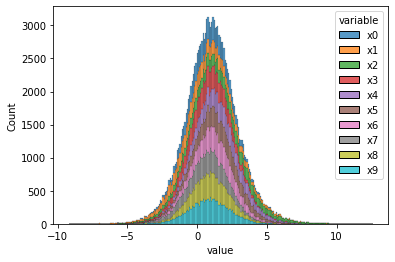

In [4]:
def plot_histogram(df, value_vars):
    df = df.copy()
    df['Index'] = np.arange(len(df))
    df = pd.melt(df, id_vars=['Index'], value_vars=value_vars)
    sns.histplot(df,
                x="value", hue="variable", multiple="stack")

plot_histogram(df, value_vars=df.columns.to_list())

array([[<AxesSubplot:title={'center':'x0'}>,
        <AxesSubplot:title={'center':'x1'}>,
        <AxesSubplot:title={'center':'x2'}>],
       [<AxesSubplot:title={'center':'x3'}>,
        <AxesSubplot:title={'center':'x4'}>,
        <AxesSubplot:title={'center':'x5'}>],
       [<AxesSubplot:title={'center':'x6'}>,
        <AxesSubplot:title={'center':'x7'}>,
        <AxesSubplot:title={'center':'x8'}>],
       [<AxesSubplot:title={'center':'x9'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

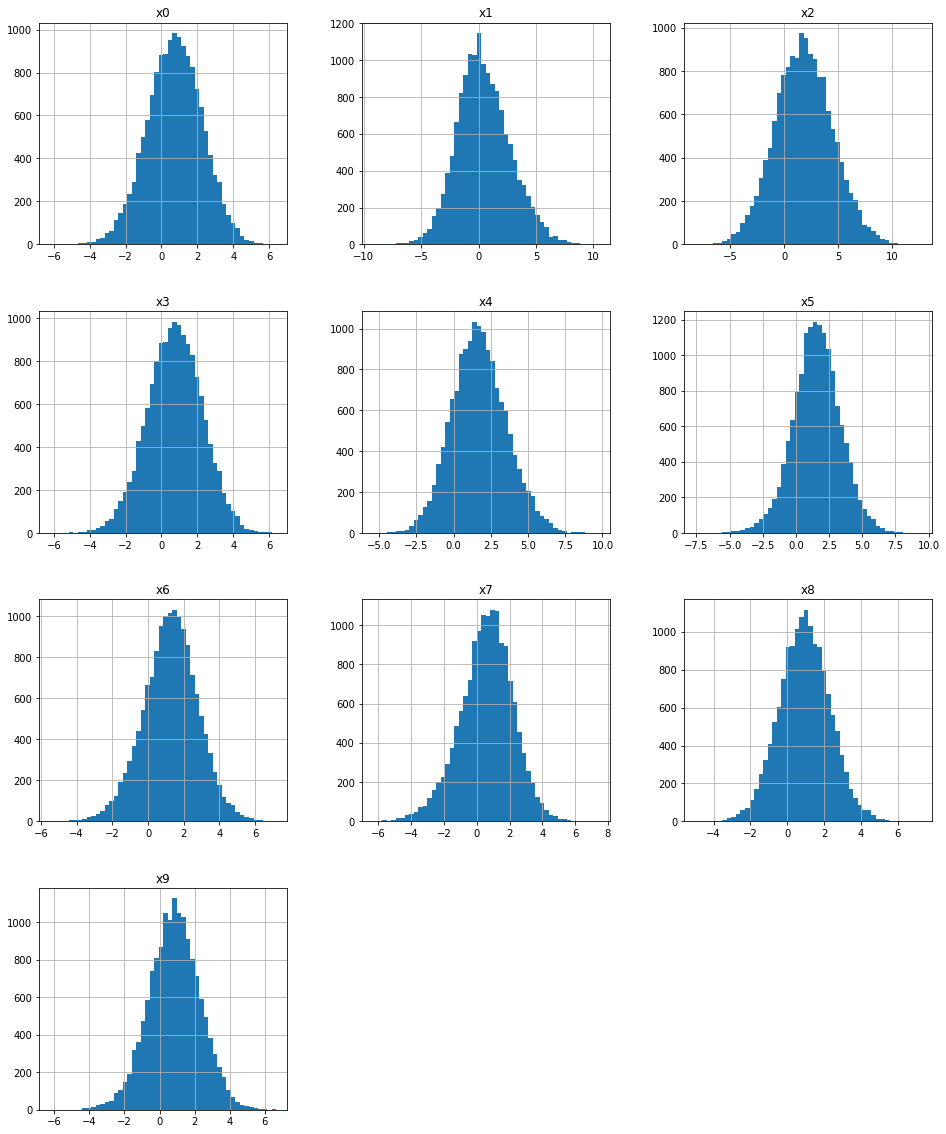

In [5]:
df.hist(figsize=(16, 20), bins=50)

Como podemos ver, aparentemente todas as variáveis tem distribuições com esse caráter Gaussiano ou Normal. Todas com o mesmo grau de escala, com os dados concentrados em -5 a 5.

### Correlação

<AxesSubplot:>

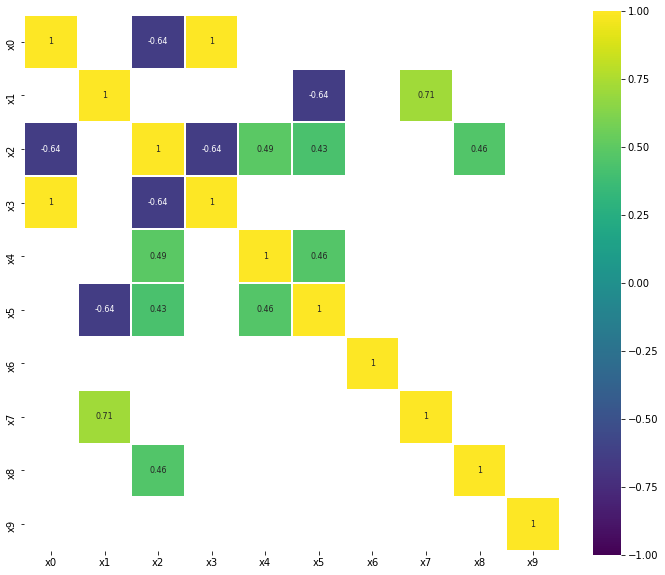

In [31]:
corr = df.corr()

plt.figure(figsize=(12, 10))

sns.heatmap(corr[abs(corr) > 0.4],
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True)

Como podemos ver tempos algumas correlação fortes. Isto pode motivar o uso de modelos que utilizariam essa possível correlação como contribuidor em determinar os grupos.

# Modelling

Embora haja outros modelos que possamos testar, como concluímos na nossa EDA temos um conjunto de variáveis que tem a distribuição Gaussiana. Um modelo muitíssimo apropriado para encontrar grupos mediante um conjunto de normais é chamado de _Modelo de Misturas Gaussiana_ ou, em inglês, _Gaussian Mixture Model_.

A idéia dele é de entender que as observações com _p_ features que temos são amostras da mistura de K variáveis Gaussianas Multivariadas sendo que cada uma delas de tamanho _p_. Em especial, essa mistura tem a estrutura de soma ponderada das Gaussianas.

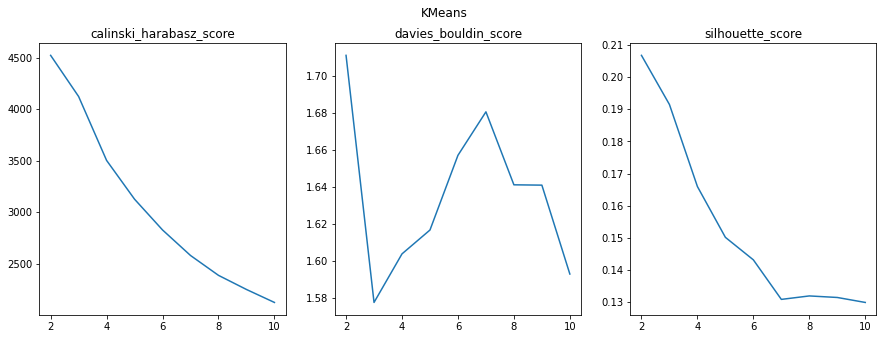

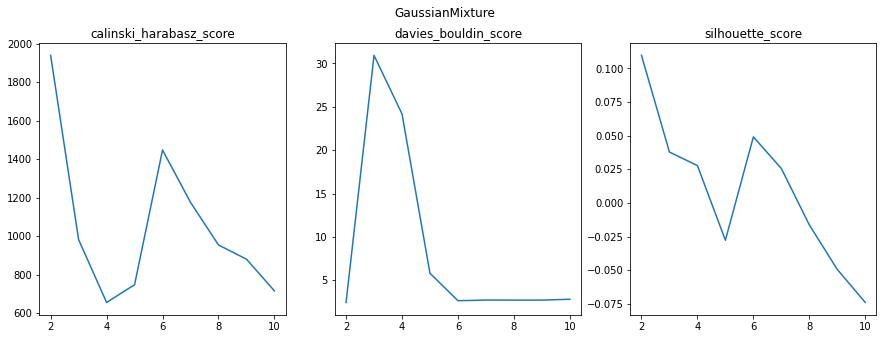

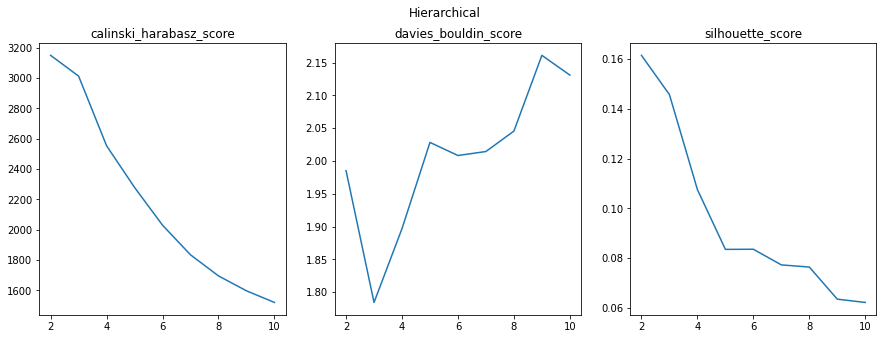

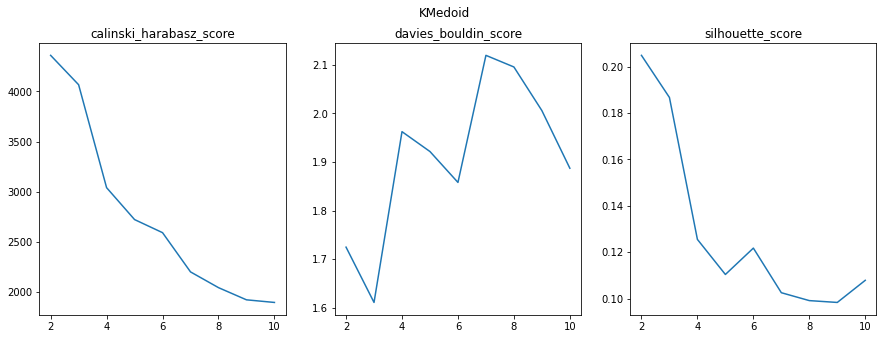

In [56]:
def calculate_scores(df, model_obj):
    X = df.copy().values
    
    score_df = pd.DataFrame()
    n_features = df.columns.str.startswith('x').shape[0]
    for k in range(2, n_features + 1):
        try:
            model_instance = model_obj(n_clusters=k)
        except:
            model_instance = model_obj(n_components=k)

        clusters = model_instance.fit_predict(X)
        
        metrics_series = pd.Series({
            'n_clusters': k,
            's_s': silhouette_score(X, clusters),
            'ch_s': calinski_harabasz_score(X, clusters),
            'db_s': davies_bouldin_score(X, clusters)
        })
        
        score_df = score_df.append(metrics_series, ignore_index=True)

    return score_df

def plot_metrics(score_df, main_title):
    fig, axs = plt.subplots(1,3,
                        figsize=(15,5))

    fig.suptitle(main_title)

    axs[0].plot(score_df['n_clusters'],
            score_df['ch_s'])
    axs[0].set_title('calinski_harabasz_score')

    axs[1].plot(score_df['n_clusters'],
            score_df['db_s'])
    axs[1].set_title('davies_bouldin_score')

    axs[2].plot(score_df['n_clusters'],
            score_df['s_s'])
    axs[2].set_title('silhouette_score')

dict_model = {
    'KMeans': KMeans,
    'GaussianMixture': GaussianMixture,
    'Hierarchical': AgglomerativeClustering,
    'KMedoid': KMedoids
}

for model_name, model in dict_model.items():
    score_df = calculate_scores(df, model)
    plot_metrics(score_df, model_name)